### Imports:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re

from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras import optimizers

from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


### Load the Data:

In [2]:
has_planets = pd.read_csv('../clean_planet_data/rand_non_null_planets.csv')

In [3]:
kep3 = pd.read_csv('../clean_planet_data/clean_cut_kepc3.csv')

In [4]:
k2c1 = pd.read_csv('../clean_planet_data/clean_cut_k2c1.csv')

In [5]:
c4_kep = pd.read_csv('../clean_planet_data/clean_kep_c4.csv')

In [6]:
all_confirmed = pd.read_csv('../clean_planet_data/all_planets_list.csv')

In [7]:
# remove last line from c4_kep because it has too many nulls:
c4_kep.drop(index=7713, inplace = True)

### Making sure there are transits in the confirmed planets set:

In [8]:
c4_kep['1'] = 0

In [9]:
c4_kep.head()

,0,1,2,3,4,5,6,7,8,9,...,4148,4149,4150,4151,4152,4153,4154,4155,4156,4157
0,KIC 1025494,0,2.633382e+05,2.633437e+05,2.633493e+05,2.632883e+05,2.634034e+05,2.633153e+05,2.633076e+05,2.633548e+05,...,2.633262e+05,2.633096e+05,2.633450e+05,2.633055e+05,2.633076e+05,2.633412e+05,2.633336e+05,2.633332e+05,2.633176e+05,2.633526e+05
1,KIC 1025578,0,1.292338e+04,1.292032e+04,1.291726e+04,1.291329e+04,1.292188e+04,1.292211e+04,1.291157e+04,1.292156e+04,...,1.291279e+04,1.291749e+04,1.292433e+04,1.292121e+04,1.291119e+04,1.291699e+04,1.291756e+04,1.293214e+04,1.293186e+04,1.290860e+04
2,KIC 1025986,0,1.276864e+06,1.277048e+06,1.277233e+06,1.277410e+06,1.277653e+06,1.277849e+06,1.278068e+06,1.278165e+06,...,1.272619e+06,1.273011e+06,1.273417e+06,1.273826e+06,1.274113e+06,1.274493e+06,1.274748e+06,1.275238e+06,1.275759e+06,1.276052e+06
3,KIC 1026032,0,1.743618e+04,1.743269e+04,1.742921e+04,1.743379e+04,1.743004e+04,1.743159e+04,1.742726e+04,1.742583e+04,...,1.739245e+04,1.739575e+04,1.739241e+04,1.740589e+04,1.739701e+04,1.738893e+04,1.740034e+04,1.739358e+04,1.738954e+04,1.738559e+04
4,KIC 1026133,0,8.089427e+04,8.089823e+04,8.090219e+04,8.091389e+04,8.088692e+04,8.089593e+04,8.087595e+04,8.091329e+04,...,8.090645e+04,8.092413e+04,8.089960e+04,8.091161e+04,8.090157e+04,8.090039e+04,8.092984e+04,8.091438e+04,8.091408e+04,8.090827e+04


In [10]:
# cut off the confidence interval, char before + or +-
#     regex?

# for each star in confirmed planet light curve set
#     find the row with the same star name
#         see if orbit > 66 days
#             drop that biz

# print something out if there are no matches

# make a list of indexs and then drop them in another cell?
# be careful of multiplanetary systems, I don't want to drop it if one planet has a long period and another one works

# if it starts with > or < then treat it like it has too long a period, after looking at all of them, I know this to be the case

# re.findall(r'Executive: .+', string)

not_found = 0
stars_to_drop = []

for j in range(len(c4_kep)): # for every light curve from has_planets
    if j % 250 == 0:
        print(j)

    count = 0
    for i in range(len(all_confirmed)): # look through each star name in the list of all confirmed planets
        try:
            if all_confirmed.loc[i, 'Alternative star names'].find(c4_kep.iloc[j, 0]) != -1:
#                 print(all_confirmed.loc[i, 'Orbital period [days]'])
                count += 1
                print(c4_kep.iloc[j, 0], ' found @ index: ', j, 'orbital period: ', all_confirmed.loc[i, 'Orbital period [days]'])
                c4_kep.loc[j, '1'] = 1
    

#                 print(re.findall(r'\d\d\d', all_confirmed.loc[i, 'Orbital period [days]']))
                
#                 if all_confirmed.loc[i, 'Orbital period [days]'] > 60:
#                     stars_to_drop.append(has_planets.iloc[j, 0])
                
    #                 continue
    #             else:
    #                 print('Nooooooope')
        except AttributeError: # if the alternate star names value are null
            try:
                if all_confirmed.loc[i, 'Star name'].find(c4_kep.iloc[j, 0]) != -1:
#                     print(all_confirmed.loc[i, 'Orbital period [days]'])
                    count += 1
                    print(c4_kep.iloc[j, 0], ' found @ index: ', j, 'on 2nd level of loop', 'orbital period: ', all_confirmed.loc[i, 'Orbital period [days]'])
                    c4_kep.loc[j, '1'] = 1
                    
#                 if all_confirmed.loc[i, 'Orbital period [days]'] > 60:
#                     stars_to_drop.append(has_planets.iloc[j, 0])
                    
    #                     continue
    #                 else:
    #                     print('Nooooooope')
            except AttributeError: # if this is null too, keep going
#                 print('Star name not found due to nulls: ', has_planets.iloc[j, 0])
                continue
    if count == 0:
        not_found += 1
#         stars_to_drop.append(has_planets.iloc[j, 0])
#         print(not_found, 'Star name not found in all_confirmed df', has_planets.iloc[j, 0])

0
KIC 10000941  found @ index:  174 orbital period:  3.5047±0.0000
250
KIC 10002866  found @ index:  265 orbital period:  3.9370±0.0000
KIC 10002866  found @ index:  265 orbital period:  28.0819±0.0001
KIC 10002866  found @ index:  265 orbital period:  10.0888±0.0000
KIC 10004519  found @ index:  328 orbital period:  9.8032±0.0000
KIC 10004738  found @ index:  338 orbital period:  56.4754±0.0002
KIC 10004738  found @ index:  338 orbital period:  92.8761±0.0008
KIC 10004738  found @ index:  338 orbital period:  13.9307±0.0001
KIC 10005788  found @ index:  398 orbital period:  10.9947±0.0000
KIC 10006581  found @ index:  430 orbital period:  40.1100±0.0002
500
KIC 10010440  found @ index:  502 orbital period:  53.5991±0.0004
KIC 10018233  found @ index:  691 orbital period:  16.2960±0.0001
KIC 10019065  found @ index:  744 orbital period:  52.6298±0.0003
750
KIC 10019643  found @ index:  771 orbital period:  21.3473±0.0001
KIC 10019643  found @ index:  771 orbital period:  7.8109±0.0001


In [11]:
c4_kep['1'].value_counts() # I counted only 5 stars with no planets with an orbit under 60 days in this set

0    7642
1      71
Name: 1, dtype: int64

In [12]:
all_confirmed.head(1) #['Orbital period [days]']

,Primary planet name,Radius [Rearth],Distance [lightyears],Orbital period [days],Number of stars in system,Primary system name,Radius [RSun],Number of planets in system,Mass [Mearth],Star name,Description,Age [Gyr],Mass [Mjup],Mass [MSun],Radius [Rjup],Alternative system names,Alternative planet names,Discovery method,Alternative star names
0,KOI-1843.03,0.61+0.12−0.08,NaN,0.1769±0.0000,1,KOI-1843,0.50±0.02,3,0.44+0.38−0.16,KOI-1843,NaN,NaN,0.0014+0.0012−0.0005,0.52±0.02,0.054+0.011−0.007,"Kepler-974, KIC 5080636",NaN,transit,"Kepler-974, KIC 5080636, 2MASS J19000314+4013147"


### Preparing Training Set:
Mixing confirmed planets into data so the model can learn what they are like

In [13]:
kep3.shape

(5087, 3199)

In [14]:
k2c1.shape

(4550, 3199)

In [15]:
has_planets.shape

(1166, 3915)

In [16]:
# cut out the extra data to compare across the same timeline
join_planets = has_planets.iloc[:,:3199]
join_planets.shape

(1166, 3199)

In [17]:
# split c4_kep to add to training data
to_train_on = c4_kep.head(2714).iloc[:,:3199]
to_train_on.columns = kep3.columns

In [18]:
# set aside a holdout set
c4_holdout = c4_kep.tail(5000).iloc[:,:3199]
c4_holdout.columns = kep3.columns

In [19]:
# make sure columns are the same

In [67]:
to_train_on.tail()

,name,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
2709,KIC 10098201,0,30738.531250,30734.998047,30731.464844,30744.189453,30737.357422,30725.398438,30727.322266,30740.234375,...,30711.484375,30708.513672,30704.792969,30716.123047,30719.189453,30699.626953,30704.642578,30691.193359,30720.410156,30690.033203
2710,KIC 10098203,0,60630.570312,60635.128906,60639.687500,60641.605469,60621.882812,60631.457031,60631.242188,60605.812500,...,60652.035156,60639.867188,60622.761719,60637.054688,60635.718750,60629.484375,60627.082031,60625.492188,60633.804688,60645.210938
2711,KIC 10098322,0,54474.214844,54476.830078,54479.445312,54454.609375,54465.417969,54467.019531,54482.117188,54474.449219,...,54470.093750,54471.281250,54482.734375,54473.542969,54476.136719,54466.660156,54478.226562,54475.183594,54473.289062,54458.718750
2712,KIC 10098323,0,19490.130859,19477.936523,19465.742188,19469.632812,19500.746094,19472.207031,19483.044922,19470.707031,...,19498.857422,19487.326172,19500.484375,19512.279297,19482.585938,19481.179688,19476.701172,19475.287109,19492.650391,19495.101562
2713,KIC 10098534,0,12773.138672,12770.885254,12768.631836,12776.298828,12772.017578,12771.841797,12779.006836,12782.492188,...,12771.104492,12784.988281,12774.524414,12778.074219,12769.102539,12787.123047,12773.678711,12776.996094,12765.583008,12781.500000


In [21]:
c4_holdout.head()

,name,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
7708,KIC 10350884,0,11319.682617,11319.583008,11319.483398,11327.371094,11326.530273,11322.001953,11325.246094,11317.274414,...,11315.725586,11318.500000,11325.413086,11309.351562,11320.790039,11326.581055,11316.476562,11317.428711,11312.616211,11308.830078
7709,KIC 10350885,0,7623.983398,7621.442383,7618.901367,7619.235352,7622.194824,7621.204590,7620.562500,7613.972168,...,7621.973633,7616.027832,7616.118164,7619.416504,7613.662109,7627.311523,7616.322266,7626.585449,7626.179688,7629.745117
7710,KIC 10350897,0,26916.777344,26915.885742,26914.994141,26919.958984,26918.572266,26908.222656,26908.228516,26914.849609,...,26923.214844,26925.933594,26918.978516,26909.220703,26917.160156,26926.078125,26914.830078,26917.787109,26912.976562,26912.085938
7711,KIC 10350908,0,34512.160156,34508.902344,34505.644531,34503.800781,34504.421875,34504.312500,34496.136719,34519.199219,...,34472.511719,34473.394531,34470.164062,34480.593750,34477.785156,34483.500000,34481.949219,34485.648438,34477.027344,34469.027344
7712,KIC 10350930,0,36407.671875,36406.587891,36405.503906,36404.976562,36405.671875,36413.835938,36398.070312,36407.812500,...,36400.039062,36392.707031,36405.394531,36406.496094,36397.617188,36407.972656,36405.117188,36405.535156,36406.671875,36400.117188


In [22]:
# make sure the dataframes have the same column names
join_planets.columns = kep3.columns
# k2c1.columns = kep3.columns

# label the confirmed planet systems with 1
join_planets['LABEL'] = 1
# k2c1['LABEL'] = 0

In [23]:
join_planets.head(1)

,name,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,KIC 10000941,1,52902.074219,52927.621094,52939.589844,52911.21875,52920.886719,52934.554688,52921.554688,52937.226562,...,50983.238281,50983.949219,50995.265625,50997.300781,50993.734375,51004.308594,50999.628906,51006.1875,51016.789062,51033.65625


In [24]:
kep3.head(1)

,name,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,NaN,1,93.85,83.81,20.1,-26.98,-39.56,-124.71,-135.18,-96.27,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54


In [76]:
master_df = pd.concat([join_planets, to_train_on], axis = 0) #kep3 removed
master_df.head(1)

,name,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,KIC 10000941,1,52902.074219,52927.621094,52939.589844,52911.21875,52920.886719,52934.554688,52921.554688,52937.226562,...,50983.238281,50983.949219,50995.265625,50997.300781,50993.734375,51004.308594,50999.628906,51006.1875,51016.789062,51033.65625


In [77]:
master_df.shape

(3880, 3199)

In [78]:
# baseline accuracy
val_count = master_df['LABEL'].value_counts()
val_count

0    2685
1    1195
Name: LABEL, dtype: int64

In [79]:
base_acc = val_count[1] / val_count.sum()
base_acc

0.3079896907216495

In [80]:
# Make X and y
X = master_df.iloc[:, 2:]
y = master_df['LABEL']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [82]:
X_train = X_train.T
X_test = X_test.T

In [83]:
X_train.head(1)

,2250,2388,277,308,2598,1659,1826,947,929,670,...,467,1542,1764,297,748,1672,2659,2313,2359,937
FLUX.1,10622.535156,17328.193359,69057.796875,12952.023438,25843.052734,16255.761719,8148.277832,103458.59375,10676.199219,91632.921875,...,179436.765625,64976.109375,196240.03125,20471.943359,195854.40625,38576.753906,29060.341797,19422.755859,120465.335938,12836.451172


In [84]:
X_test.head(1)

,999,852,1974,2090,826,1726,2400,2485,1270,400,...,903,582,954,1853,693,1292,784,740,1580,952
FLUX.1,9880.798828,12909.222656,16269.579102,499187.78125,150852.5,12304.670898,54922.261719,15879.013672,21589.730469,6260.233398,...,13748.826172,7701.056152,16517.556641,12235.956055,16096.495117,136535.375,28165.697266,7219.591797,11156.152344,49068.183594


In [85]:
# Scaling
ss = StandardScaler()

scaled_df = ss.fit_transform(X_train)
X_train = pd.DataFrame(scaled_df, columns=X_train.columns)

test_scaled_df = ss.fit_transform(X_test)
X_test = pd.DataFrame(test_scaled_df, columns=X_test.columns)

In [86]:
X_train = X_train.T
X_test = X_test.T

In [87]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
2250,-0.607318,-0.176849,0.253621,0.046283,0.363075,-0.908132,-1.057989,0.576840,-1.870078,-0.848080,...,-0.094942,-2.865447,0.187692,-1.064967,-0.248287,-1.223271,0.084114,-1.508292,-0.383636,-0.419630
2388,-0.672346,-0.549175,-0.426003,-0.188362,-0.460143,-0.086277,0.810065,0.190190,-0.758031,-0.484242,...,-0.227857,-0.370442,-1.295903,-0.782130,1.642813,-0.217147,-0.733932,0.615267,0.046936,0.254789
277,-0.360273,0.213458,0.787189,0.297611,1.292560,1.262779,-0.010575,-0.145942,-0.829546,-1.702213,...,0.623846,-0.265967,-0.290333,0.151415,0.398234,0.448771,-0.828644,-1.029438,-0.908962,-0.429310
308,-1.847858,-1.871812,-1.895765,-1.967346,-1.800114,-2.106233,-2.150306,-1.890654,-1.900783,-1.787081,...,0.808308,0.685451,1.086268,1.113614,0.917155,0.878332,1.082365,1.070563,0.825291,0.938181
2598,-0.128532,0.202311,0.533154,-0.095510,-0.531502,0.919737,1.139471,-0.459996,1.278264,1.857021,...,1.414573,-0.344542,-0.843103,0.051973,-0.293891,0.252092,0.500628,-0.260124,0.478282,-0.745278


### Prep ```c4_kep``` to be used as unseen data:

In [88]:
#  make sure this is the right size, the right number of columns


unseen_data = c4_holdout.iloc[:,2:3199]
# unseen_data.drop(index=7713, inplace = True)
# unseen_data.tail()

# scale
unseen_data = unseen_data.T

scaled_unseen = ss.fit_transform(unseen_data)
unseen_data = pd.DataFrame(scaled_unseen, columns=unseen_data.columns)

unseen_data = unseen_data.T

# unseen_data.head()

# Change the shape
array_unseen = np.array(unseen_data)
array_unseen = np.expand_dims(array_unseen, axis = 2)

### Modeling:

In [89]:
# Things to tune over
#     number of layers
#     order of layers
#     filters
#     filter size
#     nodes
#     regularization
# # Normalize outputs from previous layer.
# model.add(BatchNormalization())

# # Leaky ReLU activation function.
# model.add(LeakyReLU())

# try changing the learning rate
#     also the decay rate

# Things to try with the data itself
#     normalizing light data
#     combining confirmed planets with a different dataset
#     spline smoothing

# try changing the size of the neurons
#     meaning input dimensions?

In [90]:
# make into an array and then change the dimensions
X_array = np.array(X_train)
X_array = np.expand_dims(X_array, axis = 2)

# do this for the test set too
X_test_array = np.array(X_test)
X_test_array = np.expand_dims(X_test_array, axis = 2)

In [698]:
# Define model architecture
model = Sequential()

# Convolutional and layer.
model.add(Conv1D(filters = 5, # tuned for 5
                 kernel_size = (15),  # filter size, tuned for 15
                 activation = 'relu',
                 input_shape = (3197, 1))) # dimensions of training data
# Pooling:
model.add(MaxPooling1D(pool_size = (5))) # tuned for 5
model.add(Dropout(0.1)) # regularization tuned for .1


# Convolutional layer
model.add(Conv1D(filters = 7, # tuned for 7
                 kernel_size = 7, # tuned for 7
                 activation = 'relu'))
# Pooling layer.
model.add(MaxPooling1D(pool_size = (7))) #tuned for 7
model.add(Dropout(0.25)) # regularization tuned for .25

# Convolutional layer
model.add(Conv1D(filters = 10, # tuned to 10
                 kernel_size = 10, # tuned to 10
                 activation = 'relu'))
# Pooling layer.
model.add(MaxPooling1D(pool_size = (5))) # tuned to 5
model.add(Dropout(0.5)) # regularization tuned to .5

# In order to go from a convolutional/pooling layer, we have to organize our neurons.
model.add(Flatten())

# # Fully connected layers.
model.add(Dense(2500, activation = 'relu'))
model.add(Dropout(0.7)) # regularization tuned to .7

model.add(Dense(1000, activation = 'relu'))
model.add(Dropout(0.7)) # regularization tuned to .7


# Output layer
model.add(Dense(1, activation = 'sigmoid'))

# Changing adam optimization parameters
optimizers.adam(lr = 0.001, decay = 0)

# Compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [699]:
# best so far, .855 at ~100 epochs
# 15 times better than chance at 50 epochs, .78 acc, also at 100 epochs .81
# 12 times better than chance at 150 epochs , .86 accuracy
result = model.fit(X_array,
                    y_train,
                    batch_size = 64,
                    epochs = 150,
                    verbose = 0,
                   validation_data = (X_test_array, y_test))

Train on 2910 samples, validate on 970 samples
Epoch 1/200
2910/2910 [==============================] - 41s 14ms/step - loss: 0.6912 - acc: 0.6595 - val_loss: 0.6364 - val_acc: 0.7062
Epoch 2/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.6264 - acc: 0.6880 - val_loss: 0.6144 - val_acc: 0.6990
Epoch 3/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.6166 - acc: 0.6962 - val_loss: 0.6113 - val_acc: 0.7031
Epoch 4/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.6001 - acc: 0.7017 - val_loss: 0.5888 - val_acc: 0.7031
Epoch 5/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.6037 - acc: 0.7048 - val_loss: 0.5864 - val_acc: 0.7062
Epoch 6/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.5970 - acc: 0.7052 - val_loss: 0.5808 - val_acc: 0.7062
Epoch 7/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.5960 - acc: 0.7058 - val_loss: 0.5816 - val_acc: 0.7113
Epoch 

Epoch 61/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.4607 - acc: 0.8010 - val_loss: 0.4450 - val_acc: 0.7948
Epoch 62/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.4407 - acc: 0.8055 - val_loss: 0.4660 - val_acc: 0.7856
Epoch 63/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.4534 - acc: 0.8041 - val_loss: 0.4707 - val_acc: 0.7845
Epoch 64/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.4544 - acc: 0.7997 - val_loss: 0.4677 - val_acc: 0.7897
Epoch 65/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.4506 - acc: 0.7990 - val_loss: 0.4438 - val_acc: 0.7938
Epoch 66/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.4502 - acc: 0.8062 - val_loss: 0.4602 - val_acc: 0.7856
Epoch 67/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.4517 - acc: 0.7924 - val_loss: 0.4973 - val_acc: 0.7742
Epoch 68/200
2910/2910 [========================

2910/2910 [==============================] - 8s 3ms/step - loss: 0.4012 - acc: 0.8326 - val_loss: 0.4091 - val_acc: 0.8361
Epoch 122/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.4104 - acc: 0.8247 - val_loss: 0.4286 - val_acc: 0.8206
Epoch 123/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.4193 - acc: 0.8213 - val_loss: 0.4313 - val_acc: 0.8196
Epoch 124/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.3953 - acc: 0.8316 - val_loss: 0.4646 - val_acc: 0.8103
Epoch 125/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.4035 - acc: 0.8306 - val_loss: 0.4070 - val_acc: 0.8320
Epoch 126/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.4079 - acc: 0.8247 - val_loss: 0.4510 - val_acc: 0.8155
Epoch 127/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.4023 - acc: 0.8282 - val_loss: 0.4315 - val_acc: 0.8196
Epoch 128/200
2910/2910 [==============================

Epoch 181/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.3956 - acc: 0.8330 - val_loss: 0.4279 - val_acc: 0.8247
Epoch 182/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.3804 - acc: 0.8423 - val_loss: 0.4249 - val_acc: 0.8278
Epoch 183/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.3862 - acc: 0.8368 - val_loss: 0.4414 - val_acc: 0.8237
Epoch 184/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.3768 - acc: 0.8361 - val_loss: 0.4496 - val_acc: 0.8206
Epoch 185/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.3795 - acc: 0.8385 - val_loss: 0.4527 - val_acc: 0.8144
Epoch 186/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.3926 - acc: 0.8364 - val_loss: 0.4569 - val_acc: 0.8155
Epoch 187/200
2910/2910 [==============================] - 9s 3ms/step - loss: 0.3932 - acc: 0.8412 - val_loss: 0.4396 - val_acc: 0.8247
Epoch 188/200
2910/2910 [================

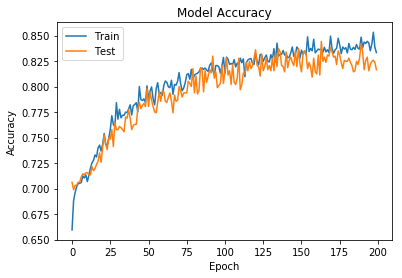

In [700]:
# Plot loss over time.
plt.figure()
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show();

### Testing on Unseen Data:
Now that the model has been fit, lets see if we can use it to detect some planets in data not seen before.

In [701]:
# predict_proba or classification
#     both, so we know what the model thinks and how confident it is
y_unseen = model.predict_classes(array_unseen)

In [702]:
# make predictions df
yhat_unseen = pd.DataFrame(y_unseen, columns=['prediction'])

# make df of true labels and index
true_y_unseen = c4_holdout['LABEL']
true_y_unseen_df = pd.DataFrame(true_y_unseen)#, columns=['true'])
true_y_unseen_df.reset_index(inplace=True)

compare_df = pd.concat((true_y_unseen_df, yhat_unseen), axis=1)#, join = 'outer')

# print out prediction rate and value_counts
val_counts = yhat_unseen['prediction'].value_counts()
print(round(val_counts[1]/val_counts.sum(), 3), '% Predicted to have planets')
print(val_counts)

# print out true rate and value_counts
val_counts2 = true_y_unseen.value_counts()
print(round(val_counts2[1]/val_counts2.sum(), 3), '% actually have planets')
print(val_counts2)

true_masked = compare_df[compare_df['LABEL'] == 1]
fp = val_counts[1] - true_masked['prediction'].sum()
tp = true_masked['prediction'].sum()

# compare predictions to true

print(tp, ' True positive planet stars predicted ',
      round((tp/val_counts[1])*100, 2), '% of all predictions',
     round((tp/val_counts[1])/(val_counts2[1]/val_counts2.sum()), 2), ' times better than chance')
print(fp, ' False postives', round((fp / val_counts[1])*100, 2), '% of all predicted')


0.013 % Predicted to have planets
0    4934
1      66
Name: prediction, dtype: int64
0.008 % actually have planets
0    4958
1      42
Name: LABEL, dtype: int64
8  True positive planet stars predicted  12.12 % of all predictions 14.43  times better than chance
58  False postives 87.88 % of all predicted


In [614]:
#### confusion matrix:


<hr>

In [134]:
# compare predictions to true
# yhat_unseen['true'] = true_y_unseen
true_masked = compare_df[compare_df['LABEL'] == 1]
print(true_masked['prediction'].sum(), ' True planet systems predicted ',
      round(true_masked['prediction'].sum()/len(true_masked),3)*100, '% of true')

7  True planet systems predicted  16.7 % of true


In [ ]:
# take a look at the unseen data
x_axis = list(range(unseen_data.shape[1]-2))
plt.scatter(x_axis, unseen_data.iloc[4028, 2:])
# plt.ylim(-2, 2)

### Example of a Transit:

In [ ]:
x_axis = list(range(join_planets.shape[1]-2))
plt.scatter(x_axis, join_planets.iloc[23, 2:])
# plt.ylim(10040, 10090)
plt.xlabel('Time')
plt.ylabel('Flux Level')
plt.title('Possible Solar Flare')

### Notes <hr>

In [ ]:
# # Evaluate model on test data
# score = model.evaluate(X_test_array, y_test, verbose = 1)
# labels = model.metrics_names

# score
# # labels
# # model.summary()

In [ ]:
# # What is the best way to do this?
# undersample?
# oversample?
# What is the best ratio?
# will this affect my result/ my false positive rate?

# change columns of kep3 so you can join it with the planet data
#     make sure there are no gaps in the confirmed planets data
#     or the other data
#     cut down dfs to be the right size
#     do I want to remove the confimed planets already in the kep3 set in case they are repeats?

# is it possible that some of the planets don't pass in front of their stars for the 66 days I'm looking at?
#     what proportion of exoplanets have orbits of less than 66 days?

# how am I going to deal with the nulls?
#     skip to the next nearest non-null value?
#     how many nulls in a row are there?
#     if this happens to almost all confirmed planets, its possible that the network may learn to find these "skips"
#         should I then just drop any rows with too many consecutive nans? 
#         Pretty much every one has a string of at least 40 consecutive nans
#     mean imputation may have a logical case here
#         it would make sense that the level of light is between previous value and the next one + random noise
#         what about for longer strings of missing values 
#         mean imputation could be good for avoiding creating false signals because of its smoothing effect
#         the disadvantages of mean imputation may not be important because I am basically using neural networks for pattern detection
#     maybe if it is a long string of missing values you want to skip to the next real data, 
#         mark if that had happened so I could tell if it contributes to false positives
#     drop rows with more than 150 nulls? there are only 8
#         1134    666
#         752     408
#         851     408
#         1105    408
#         441     408
#         832     285
#         871     230
#         762     230

# definitely get data on whether it is a binary star system or not
#     how to feed these single features to the neural networks to help with pattern detection?

# normalize the light curves

# print out confusion matrix and other classification metrics

# turn it into a gridsearch
#     have it save the results to be analyzed later
#     can I have it tune over generalizability to the unseen set?